# Implementation of Perelson et al.

In this implementation we're going to evaluate the properties of a [dynamical model](http://science.sciencemag.org/content/271/5255/1582).

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

### (1) Reproduce all four panels from Figure 1 shown in Perelson et al. using eq. 6

Since we are not given any empirical data, use the fitted parameters and the appropriate constants to generate the curves shown on these plots. Remember to account for the time delays for each patient.

#### (i) Implement eq. 6 from the paper as a function.

In [52]:
import numpy as np

# Function to compute the equation with given parameters
def compute_equation(t, initial_velocity, coefficient_1, coefficient_2, time_delay, scale=1):  
    # Scale the initial velocity if necessary
    initial_velocity = initial_velocity * scale
    # Adjust time with time delay
    t = t - time_delay
    # Compute v_i using the first exponential term
    v_i = (initial_velocity * np.exp(-coefficient_1 * t))
    # Compute v_ni using the second exponential term
    v_ni = (coefficient_1 * initial_velocity / (coefficient_1 - coefficient_2)) * ((coefficient_1 / (coefficient_1 - coefficient_2)) * (np.exp(-coefficient_2 * t) - np.exp(-coefficient_1 * t)) - coefficient_2 * t * np.exp(-coefficient_1 * t))

    # Adjust v_i and v_ni for t < 0.0
    v_i[t < 0.0] = initial_velocity
    v_ni[t < 0.0] = 0
        
    # Return the computed values of v_i, v_ni and their sum
    return v_i, v_ni, v_i + v_ni

# Generate an array of timepoints
timepoints = np.linspace(0.01, 8, num=1000)
patient_104 = compute_equation(timepoints, 52000, 3.68, 0.50, 2/24, 2)
patient_105 = compute_equation(timepoints, 643000, 2.06, 0.53, 6/24, 2)
patient_107 = compute_equation(timepoints, 77000, 3.09, 0.50, 2/24, 2)

#### (ii) Make the plot from this function's values over time.

Note that some constants are given in other papers published by this lab. An estimate of k, the viral infectivity rate, can be found in Wein et al. (J. Theor. Biol. 192:81-98) to be $3.43\times10^{-8}$ mL/(virion•day). Note that you will need to solve ordinary differential equations for $T^*$, $V_I$, and $V_{NI}$ to reproduce the data in Figure 1.

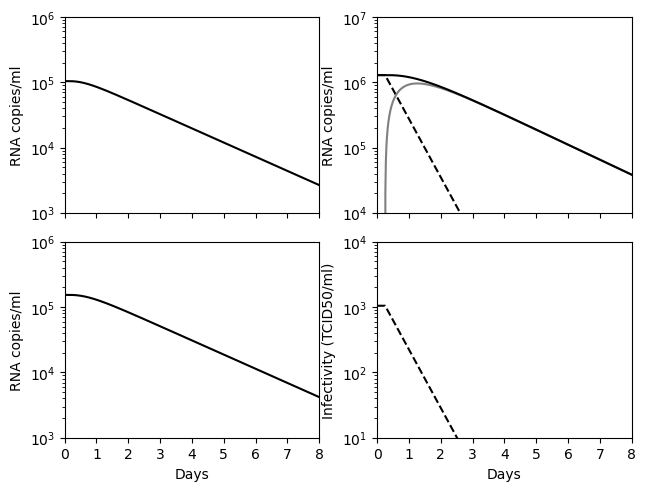

In [53]:
# Function to configure axes limits and ticks
def set_axes_limits(axs):
    for ax_list in axs:
        for ax in ax_list:
            ax.set_xlim([0, 8])
            ax.set_xticks(range(9))

# Initial virus quantity and infectivity coefficient
initial_virus_qty = 643E3 * 2
initial_tcid50 = 1.05E3
infectivity_coeff = initial_tcid50 / initial_virus_qty

# Create subplot and set layout
fig, axs = plt.subplots(2, 2, sharex=True)
fig.tight_layout()

# Plot patient data on each axis
axs[0][0].semilogy(timepoints, patient_104[2], color='k')
axs[1][0].semilogy(timepoints, patient_107[2], color='k')
axs[0][0].set_ylim([1E3, 1E6])
axs[1][0].set_ylim([1E3, 1E6])

axs[0][1].semilogy(timepoints, patient_105[0], color='k', linestyle='--')
axs[0][1].semilogy(timepoints, patient_105[1], color='grey')
axs[0][1].semilogy(timepoints, patient_105[2], color='k')
axs[0][1].set_ylim([1E4, 1E7])

axs[1][1].semilogy(timepoints, patient_105[0] * infectivity_coeff, color='k', linestyle='--')
axs[1][1].set_ylim([10, 1E4])

# Call function to configure axes limits and labels
set_axes_limits(axs)
axs[1][0].set_xlabel('Days')
axs[1][1].set_xlabel('Days')
axs[0][0].set_ylabel('RNA copies/ml')
axs[1][0].set_ylabel('RNA copies/ml')
axs[0][1].set_ylabel('RNA copies/ml')
axs[1][1].set_ylabel('Infectivity (TCID50/ml)')

# Show the plot
plt.show()


### (2) Can the model of virion production before treatment show stable or unstable oscillations?

Justify your answer.

In order to determine the stability of the system, we need to analyze the eigenvalues of the Jacobian matrix associated with the system of ordinary differential equations (ODEs) that we are working with. This system of ODEs consists of two equations describing the rates of change for two variables, namely T* and V, and is given by:

$$
\frac{dT^*}{dt} = kVT - \delta T^* \\
\frac{dV}{dt} = N\delta T^* - cV
$$

Jacobian for this system of ODEs is:

$$
Jacobian = 
\begin{bmatrix}
    -\delta & kT \\
    N \delta & -c
\end{bmatrix}
$$

By substituting the parameter values obtained from our patients and analyzing the eigenvalues, we will consistently obtain two real eigenvalues that are negative, indicating that the system is stable and there will be no oscillations.





### (3) Reimplement the model relaxing the assumption about T remaining constant by numerically solving the system of ODEs.

#### i. Define a function that takes each parameter as a vector and outputs the time derivative of each species.

In [54]:
def ode_func(y, t, k, T0, delta, c, N, mu, delay):
    if t < delay:
        return 0, 0, 0

    T_star = y[0]
    V_i = y[1]
    V_ni = y[2]
    
    dT_star = (k * V_i * (T0 - T_star)) - (delta * T_star)
    dV_i = -c * V_i + (1 - mu) * N * delta * T_star
    dV_ni = mu * N * delta * T_star - (c * V_ni)
    return dT_star, dV_i, dV_ni

#### ii. Use odeint to solve this system of equations numerically for patient 105.

Hint: For ease later, it may be helpful to make a function here that handles everything but takes in gnu.

In [55]:
from scipy.integrate import odeint

def run_ode_solver(timepoints, V_i0, k, T0, delta, c, mu, delay):
    N = c / (k * T0)
    args = (
        k,
        T0,
        delta,
        c,
        N,
        mu,
        delay
    )
    
    V_ni0 = 0
    T_star0 = k * V_i0 * T0 / delta 
    y0 = (
        T_star0,
        V_i0,
        V_ni0
    )
    
    return odeint(ode_func, y0, timepoints, args=args)
    

V_i0 = 643E3 * 2
timepoints = np.linspace(0.01, 8, num=1000)

patient_105_num = run_ode_solver(timepoints, V_i0, 3.43E-8, 11E3, 0.53, 2.06, 1, 6/24)

#### iii. Reproduce the subpanels of Fig. 1 with this updated model. 

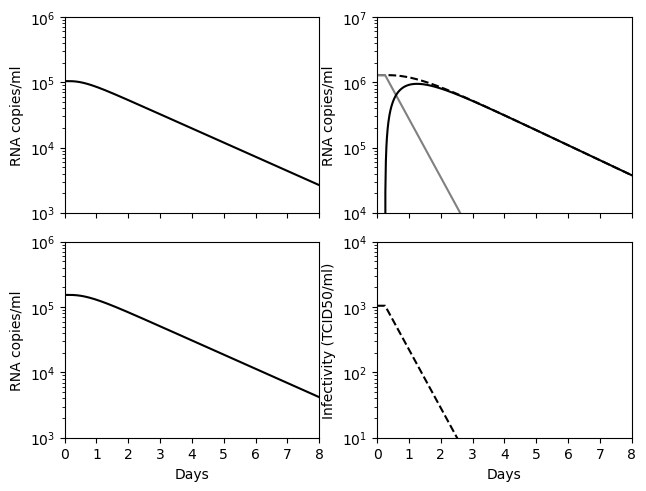

In [56]:
patient_104_num = run_ode_solver(timepoints, 52E3 * 2, 3.43E-8, 2E3, 0.5, 3.68, 1, 2/24)
patient_107_num = run_ode_solver(timepoints, 77E3 * 2, 3.43E-8, 412E3, 0.5, 3.09, 1, 2/24)

fig, axs = plt.subplots(2, 2, sharex=True)
fig.tight_layout()

axs[0][0].semilogy(timepoints, patient_104_num[:, 1] + patient_104_num[:, 2], color='k')
axs[1][0].semilogy(timepoints, patient_107_num[:, 1] + patient_107_num[:, 2], color='k')
axs[0][0].set_ylim([1E3, 1E6])
axs[1][0].set_ylim([1E3, 1E6])

axs[0][1].semilogy(timepoints, patient_105_num[:, 1] + patient_105_num[:, 2], color='k', linestyle='--')
axs[0][1].semilogy(timepoints, patient_105_num[:, 1], color='grey')
axs[0][1].semilogy(timepoints, patient_105_num[:, 2], color='k')
axs[0][1].set_ylim([1E4, 1E7])

axs[1][1].semilogy(timepoints, patient_105_num[:, 1] * infect_coeff, color='k', linestyle='--')
axs[1][1].set_ylim([10, 1E4])

configure_axs(axs)
axs[1][0].set_xlabel('Days')
axs[1][1].set_xlabel('Days')
axs[0][0].set_ylabel('RNA copies/ml')
axs[1][0].set_ylabel('RNA copies/ml')
axs[0][1].set_ylabel('RNA copies/ml')
axs[1][1].set_ylabel('Infectivity (TCID50/ml)')

plt.show()

#### iv. Are the results the same as in (1)?

Show evidence of your conclusion.

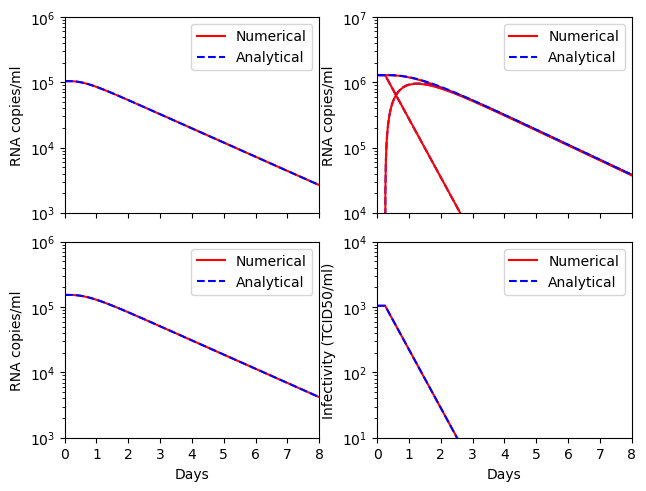

In [57]:
def add_legends(axs):
    for ax_list in axs:
        for ax in ax_list:
            ax.legend(['Numerical', 'Analytical'])

fig, axs = plt.subplots(2, 2, sharex=True)
fig.tight_layout()

axs[0][0].semilogy(timepoints, patient_104_num[:, 1] + patient_104_num[:, 2], color='red')
axs[0][0].semilogy(timepoints, patient_104[2], color='blue', linestyle='--')
axs[1][0].semilogy(timepoints, patient_107_num[:, 1] + patient_107_num[:, 2], color='red')
axs[1][0].semilogy(timepoints, patient_107[2], color='blue', linestyle='--')
axs[0][0].set_ylim([1E3, 1E6])
axs[1][0].set_ylim([1E3, 1E6])

axs[0][1].semilogy(timepoints, patient_105_num[:, 1] + patient_105_num[:, 2], color='red')
axs[0][1].semilogy(timepoints, patient_105[0], color='blue', linestyle='--')
axs[0][1].semilogy(timepoints, patient_105_num[:, 1], color='red')
axs[0][1].semilogy(timepoints, patient_105[1], color='blue', linestyle='--')
axs[0][1].semilogy(timepoints, patient_105_num[:, 2], color='red')
axs[0][1].semilogy(timepoints, patient_105[2], color='blue', linestyle='--')
axs[0][1].set_ylim([1E4, 1E7])

axs[1][1].semilogy(timepoints, patient_105_num[:, 1] * infect_coeff, color='red')
axs[1][1].semilogy(timepoints, patient_105[0] * infect_coeff, color='blue', linestyle='--')
axs[1][1].set_ylim([10, 1E4])

configure_axs(axs)
add_legends(axs)
axs[1][0].set_xlabel('Days')
axs[1][1].set_xlabel('Days')
axs[0][0].set_ylabel('RNA copies/ml')
axs[1][0].set_ylabel('RNA copies/ml')
axs[0][1].set_ylabel('RNA copies/ml')
axs[1][1].set_ylabel('Infectivity (TCID50/ml)')

plt.show()

From the plots above, we indeed find that our two methods produce nearly identical results as the plots of the systems are coincidental in the above figures.

### (4) Repeat the work that the authors describe in item 12 of their “References and Notes”.

#### (i) Namely, vary the effectiveness factor of the drug (η=1.0, 0.99, 0.95, and 0.90) and simulate the viral load that would result from the modified differential equations using the parameters c=3.0 days$^{-1}$ and δ=0.5 days$^{-1}$ as described in item 12 and the values of T0, V0, and the time delay provided for patient 105.

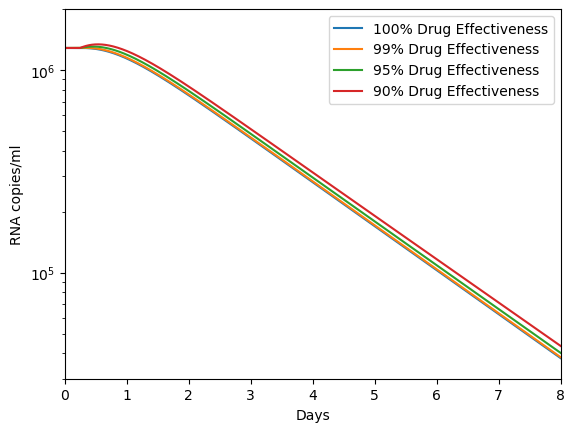

In [58]:
timepoints = np.linspace(0.01, 8, num=1000)

patient_105_100 = run_ode_solver(timepoints, V_i0, 3.43E-8, 11E3, 0.5, 3, 1, 6/24)
patient_105_99 = run_ode_solver(timepoints, V_i0, 3.43E-8, 11E3, 0.5, 3, 0.99, 6/24)
patient_105_95 = run_ode_solver(timepoints, V_i0, 3.43E-8, 11E3, 0.5, 3, 0.95, 6/24)
patient_105_90 = run_ode_solver(timepoints, V_i0, 3.43E-8, 11E3, 0.5, 3, 0.90, 6/24)

plt.semilogy(timepoints, patient_105_100[:, 1] + patient_105_100[:, 2])
plt.semilogy(timepoints, patient_105_99[:, 1] + patient_105_100[:, 2])
plt.semilogy(timepoints, patient_105_95[:, 1] + patient_105_100[:, 2])
plt.semilogy(timepoints, patient_105_90[:, 1] + patient_105_100[:, 2])

plt.ylim([3E4, 2E6])
plt.xlim([0, 8])
plt.xlabel('Days')
plt.ylabel('RNA copies/ml')
plt.legend(['100% Drug Effectiveness',
            '99% Drug Effectiveness',
            '95% Drug Effectiveness',
            '90% Drug Effectiveness'])
plt.show()

#### (ii) Then, use the function `scipy.optimize.leastsq` to fit this data to the equation for V(t) given in the paper and find the estimates of c and δ that result. Fit only the portion of the curve after the pharmacokinetic delay. Compare these estimates to the actual values for c and δ and discuss the consequences of an imperfect drug on clearance time estimates.

In [59]:
from scipy.optimize import leastsq

delay = 6/24
p0 = [3.09, 0.53]
baseline = run_ode_solver(timepoints, V_i0, 3.43E-8, 11E3, 0.53, 2.06, 1.0, delay)

def lsq_function(params, gnu):
    c, delta = params
    one = run_ode_solver(timepoints, V_i0, 3.43E-8, 11E3, delta, c, gnu, delay)
    return one[:, 1] + one[:, 2] - baseline[:, 1] - baseline[:, 2]

lsq_100 = leastsq(lsq_function, p0, args=(1.0, ), full_output=True)
lsq_99 = leastsq(lsq_function, p0, args=(0.99, ), full_output=True)
lsq_95 = leastsq(lsq_function, p0, args=(0.95, ), full_output=True)
lsq_90 = leastsq(lsq_function, p0, args=(0.9, ), full_output=True)

print(f'                            c     delta')
print(f'        Paper Estimates:  3.09     0.53')
print(f'100% Drug Effectiveness:  {round(lsq_100[0][0], 2)}     {round(lsq_100[0][1], 2)}')
print(f' 99% Drug Effectiveness:  {round(lsq_99[0][0], 2)}     {round(lsq_99[0][1], 2)}')
print(f' 95% Drug Effectiveness:  {round(lsq_95[0][0], 2)}     {round(lsq_95[0][1], 2)}')
print(f' 90% Drug Effectiveness:  {round(lsq_90[0][0], 2)}     {round(lsq_90[0][1], 2)}')

                            c     delta
        Paper Estimates:  3.09     0.53
100% Drug Effectiveness:  2.06     0.53
 99% Drug Effectiveness:  2.06     0.54
 95% Drug Effectiveness:  2.04     0.57
 90% Drug Effectiveness:  2.01     0.61


#### (iii) Examine the residual plots from your fits to determine whether or not there is a trend in the error associated with fitting these new curves.

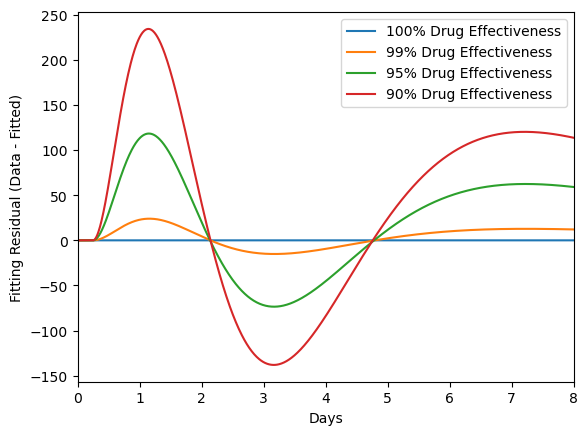

In [36]:
plt.plot(timepoints, lsq_100[2]["fvec"])
plt.plot(timepoints, lsq_99[2]["fvec"])
plt.plot(timepoints, lsq_95[2]["fvec"])
plt.plot(timepoints, lsq_90[2]["fvec"])

plt.xlim([0, 8])
plt.xlabel('Days')
plt.ylabel('Fitting Residual (Data - Fitted)')
plt.legend(['100% Drug Effectiveness',
            '99% Drug Effectiveness',
            '95% Drug Effectiveness',
            '90% Drug Effectiveness'])

plt.show()

### (5) To determine the TCID50 one should estimate an infectivity coefficient.

To calculate the infectivity coefficient, estimate the ratio of $V_I(t=0)$ to the value of TCID50(t=0) for patient 105 from Perelson’s Figure 1. This coefficient acts as a conversion factor between the number of virions in the infectious pool, $V_I$, and the TCID50, and is an indicator of the efficiency of the HIV-1 transmission.

Estimated Infectivity Coefficient: 0.0008164852255054432

Re-done Figure 1 plots (with infectivity coefficient):


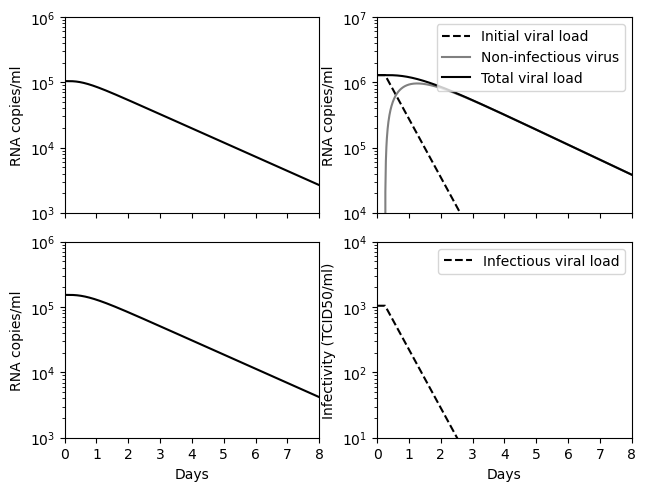

In [22]:
V_i0 = 643E3 * 2
TCID50_0 = 1.05E3
infect_coeff = TCID50_0 / V_i0

print(f'Estimated Infectivity Coefficient: {infect_coeff}')

fig, axs = plt.subplots(2, 2, sharex=True)
fig.tight_layout()

axs[0][0].semilogy(timepoints, patient_104[2], color='k')
axs[1][0].semilogy(timepoints, patient_107[2], color='k')
axs[0][0].set_ylim([1E3, 1E6])
axs[1][0].set_ylim([1E3, 1E6])

axs[0][1].semilogy(timepoints, patient_105[0], color='k', linestyle='--')
axs[0][1].semilogy(timepoints, patient_105[1], color='grey')
axs[0][1].semilogy(timepoints, patient_105[2], color='k')
axs[0][1].set_ylim([1E4, 1E7])

axs[1][1].semilogy(timepoints, patient_105[0] * infect_coeff, color='k', linestyle='--')
axs[1][1].set_ylim([10, 1E4])

configure_axs(axs)
axs[1][0].set_xlabel('Days')
axs[1][1].set_xlabel('Days')
axs[0][0].set_ylabel('RNA copies/ml')
axs[1][0].set_ylabel('RNA copies/ml')
axs[0][1].set_ylabel('RNA copies/ml')
axs[1][1].set_ylabel('Infectivity (TCID50/ml)')

print('\nRe-done Figure 1 plots (with infectivity coefficient):')

plt.show()